In [45]:
import os
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

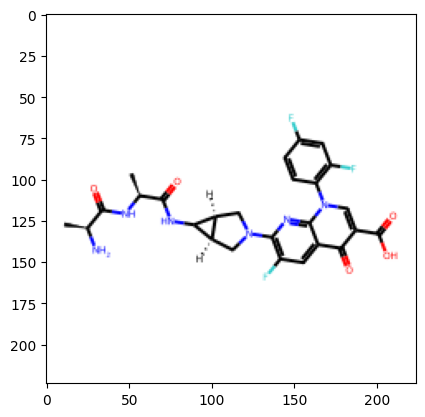

In [46]:
# Load sucrose from SMILES
smile_example = "C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN(C2)C3=C(C=C4C(=O)C(=CN(C4=N3)C5=C(C=C(C=C5)F)F)C(=O)O)F)N"
mol = Chem.MolFromSmiles(smile_example)

# Draw 3D structure
img = Draw.MolToImage(mol, size=(224, 224))
plt.imshow(img)

# Save image
img.save("data_smiles/sucrose.png")

c1(F)ccc(-n2c3c(c(=O)c(C(=O)O)c2)cc(F)c(N2C[C@H]4C(NC([C@H](C)NC([C@H](C)N)=O)=O)[C@H]4C2)n3)c(F)c1
c1c(-n2c3c(c(=O)c(C(=O)O)c2)cc(F)c(N2C[C@H]4[C@@H](C2)C4NC([C@@H](NC([C@H](C)N)=O)C)=O)n3)c(F)cc(F)c1
C[C@@H](C(NC1[C@H]2CN(c3nc4n(-c5ccc(F)cc5F)cc(C(=O)O)c(=O)c4cc3F)C[C@H]21)=O)NC([C@H](C)N)=O
c12c(c(=O)c(C(=O)O)cn1-c1ccc(F)cc1F)cc(F)c(N1C[C@@H]3C(NC([C@@H](NC([C@H](C)N)=O)C)=O)[C@@H]3C1)n2
c1(F)cc2c(nc1N1C[C@@H]3C(NC([C@H](C)NC(=O)[C@H](C)N)=O)[C@@H]3C1)n(-c1ccc(F)cc1F)cc(C(O)=O)c2=O


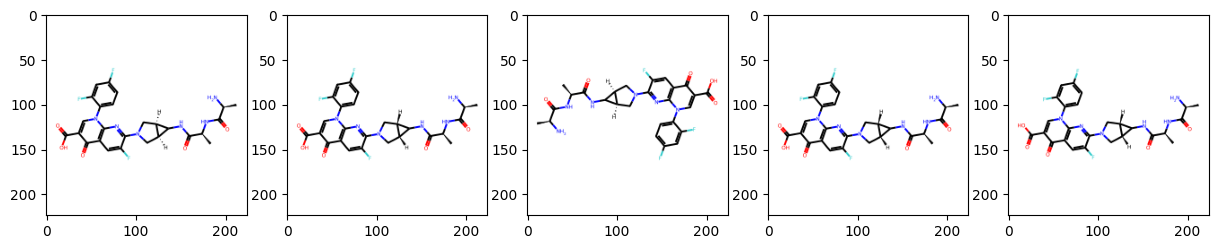

In [47]:
# data augmentation
from utils.SmilesEnumeration import SmilesEnumerator

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
sme = SmilesEnumerator()
for i in range(5):
    example_randomized = sme.randomize_smiles(smile_example)
    print(example_randomized)

    mol = Chem.MolFromSmiles(example_randomized)

    # Draw 3D structure
    img = Draw.MolToImage(mol, size=(224, 224))
    axes[i].imshow(img)

# Generate images

In [49]:
# load training data
import pandas as pd

pd_data_train = pd.read_csv("data_smiles/Training_Group.csv")
print(pd_data_train.shape)
pd_data_train.head()

(1241, 2)


,Smiles,Liver
0,S=C=Nc1c2c(ccc1)cccc2,Hepatotoxicity
1,c1(c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[...,Hepatotoxicity
2,c1(c(cc(cc1)[N+](=O)[O-])[N+](=O)[O-])O,Hepatotoxicity
3,O(CCO)CC,Hepatotoxicity
4,Oc1cc2c(cc1)cccc2,Hepatotoxicity


In [50]:
pd_data_test = pd.read_csv("data_smiles/Testing_Group.csv")
print(pd_data_test.shape)
pd_data_test.head()

(286, 2)


,Smiles,Liver
0,C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN...,Hepatotoxicity
1,C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl,Hepatotoxicity
2,CCCN(CCC)C(=O)CC1=C(N=C2N1C=C(C=C2)Cl)C3=CC=C(...,Hepatotoxicity
3,C1CC2=CC=CC=C2C(C3=CC=CC=C31)NCCCCCCC(=O)O,Hepatotoxicity
4,C1=CC=C(C=C1)CN2C3=CC=CC=C3C(=N2)OCC(=O)O,Hepatotoxicity


In [52]:
# save SMILES images from training data
sme = SmilesEnumerator()
for i, row in pd_data_train.iterrows():
    smile = row["Smiles"]
    class_label = row["Liver"]

    # make sure the folder exists
    os.makedirs(f"data_smiles/Training_Group/{class_label}", exist_ok=True)
    os.makedirs(f"data_smiles/Training_Group_Augmented/{class_label}", exist_ok=True)

    # using positive hash
    smile_normalized = str(hash(smile) % ((1 << 31) - 1))

    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol, size=(224, 224))
    img.save(f"data_smiles/Training_Group/{class_label}/{smile_normalized}.png")

    # data augmentation
    for j in range(5):
        example_randomized = sme.randomize_smiles(smile)
        mol = Chem.MolFromSmiles(example_randomized)
        img = Draw.MolToImage(mol, size=(224, 224))
        img.save(
            f"data_smiles/Training_Group_Augmented/{class_label}/{smile_normalized}_{j}.png"
        )

In [53]:
# save SMILES images from Testing data
sme = SmilesEnumerator()
for i, row in pd_data_test.iterrows():
    smile = row["Smiles"]
    class_label = row["Liver"]

    # make sure the folder exists
    os.makedirs(f"data_smiles/Testing_Group/{class_label}", exist_ok=True)

    # using positive hash
    smile_normalized = str(hash(smile) % ((1 << 31) - 1))

    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol, size=(224, 224))
    img.save(f"data_smiles/Testing_Group/{class_label}/{smile_normalized}.png")

# Calculate normalize mean and std

In [36]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

In [37]:
def calculate_mean_std_multiple_dirs(directories):
    channel_sum = np.zeros(3)
    channel_sum_squared = np.zeros(3)
    total_pixels = 0

    for image_folder in directories:
        image_files = [
            os.path.join(image_folder, f)
            for f in os.listdir(image_folder)
            if f.endswith(".png")
        ]

        for img_file in tqdm(image_files, desc=f"Processing {image_folder}"):
            img = Image.open(img_file).convert("RGB")
            img_array = np.array(img) / 255.0

            channel_sum += img_array.sum(axis=(0, 1))
            channel_sum_squared += (img_array**2).sum(axis=(0, 1))
            total_pixels += img_array.shape[0] * img_array.shape[1]

    mean = channel_sum / total_pixels
    std = np.sqrt(channel_sum_squared / total_pixels - mean**2)

    return mean, std

In [39]:
# Directories for both training datasets
train_dirs = ["data_smiles/Training_Group", "data_smiles/Training_Group_Augmented"]

# Calculate mean and std across multiple directories
mean, std = calculate_mean_std_multiple_dirs(train_dirs)
print(f"Mean: {mean}:.3f")
print(f"Std: {std}:.3f")

Processing data_smiles/Training_Group_Augmented: 100%|██████████| 6205/6205 [00:13<00:00, 469.68it/s]

Mean: [0.97504467 0.97167537 0.97449775]
Std: [0.1405735  0.14853673 0.14202789]
